In [113]:
import numpy as np

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt

rs = 42

# Part 1 - Data Preprocessing

## Split into train , test data

In [114]:
# train, test split
splitfolders.ratio('./data/humanModel/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 1317 files [00:02, 639.46 files/s]


### Preprocessing the Training set

In [115]:
batch_size = 64
img_height = 10
img_width = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/train',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/val',
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 941 files belonging to 5 classes.
Found 421 files belonging to 5 classes.
['32', '37', '38', '39', '40']


In [116]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## View some data

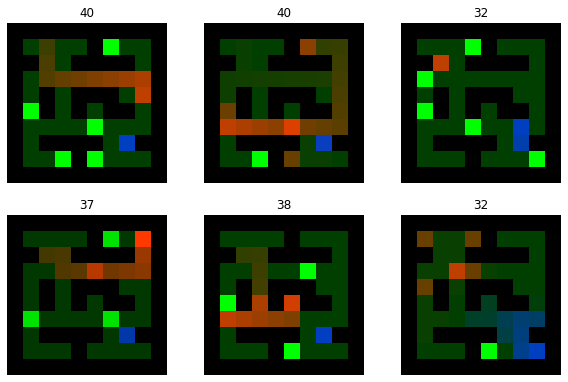

In [117]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [118]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

In [119]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 10, 10, 16)        448       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 2, 2, 64)         

In [121]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
15/15 [==============================] - 2s 76ms/step - loss: 4.4343 - accuracy: 0.2635 - val_loss: 4.0259 - val_accuracy: 0.2898
Epoch 2/50
15/15 [==============================] - 1s 37ms/step - loss: 3.7121 - accuracy: 0.2922 - val_loss: 3.3856 - val_accuracy: 0.2874
Epoch 3/50
15/15 [==============================] - 1s 47ms/step - loss: 3.1390 - accuracy: 0.2965 - val_loss: 2.8877 - val_accuracy: 0.3634
Epoch 4/50
15/15 [==============================] - 0s 22ms/step - loss: 2.7092 - accuracy: 0.2954 - val_loss: 2.5158 - val_accuracy: 0.3064
Epoch 5/50
15/15 [==============================] - 0s 23ms/step - loss: 2.3840 - accuracy: 0.3061 - val_loss: 2.2251 - val_accuracy: 0.3539
Epoch 6/50
15/15 [==============================] - 0s 23ms/step - loss: 2.1298 - accuracy: 0.3316 - val_loss: 2.0160 - val_accuracy: 0.3705
Epoch 7/50
15/15 [==============================] - 0s 23ms/step - loss: 1.9423 - accuracy: 0.3804 - val_loss: 1.8489 - val_accuracy: 0.3919
Epoch 8/50
15

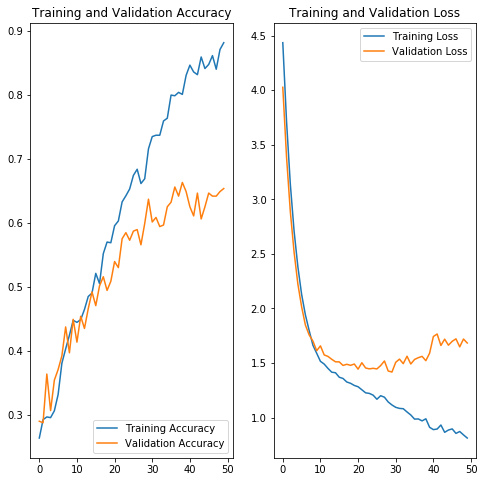

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [123]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

7/7 [==============================] - 0s 7ms/step - loss: 1.6836 - accuracy: 0.6532
Test accuracy : 0.6532066464424133


In [124]:
# Save the entire model as a SavedModel.
model.save('./data/humanModel/mode_v0')

INFO:tensorflow:Assets written to: ./data/humanModel/mode_v0\assets


In [125]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [126]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/37/-MhUR_hORqFZDHLqxzMH_2.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 37 with a 65.29 percent confidence.
